<a href="https://colab.research.google.com/github/Yasertb/Google-Earth-Engine/blob/main/IntroGEE_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import ee
import geemap as gee

In [114]:
ee.Authenticate()
ee.Initialize(project='ee-tahmasebiyaser')

In [115]:
Map = gee.Map(basemap= 'SATELLITE')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [116]:
# Define the urban location of interest as a point near Ahvaz, France.
u_lon = 48.68
u_lat = 31.34
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 48.86
r_lat = 31.48
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [117]:
Map.addLayer(u_poi, {'color': 'blue'}, 'Urban location')
Map.addLayer(r_poi, {'color': 'orange'}, 'Rural location')

In [118]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [119]:
# Initial date of interest (inclusive).
i_date = '2020-01-01'

# Final date of interest (exclusive).
f_date = '2023-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [120]:
scale = 1000;
elv_urban_point  = elv.sample(u_poi,scale).first().get('elevation').getInfo()
elv_urban_point

20

In [121]:
lst_urban_point = lst.first().sample(u_poi,scale).first().get('LST_Day_1km').getInfo()
round((lst_urban_point*0.02)-273.15)

16

In [122]:
lc_urban_point = lc.first().sample(u_poi,scale).first().get('LC_Type1').getInfo()
lc_urban_point

13

In [123]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2020_01_01',
  48.68419682285747,
  31.337728686509507,
  1577836800000,
  14494,
  65],
 ['2020_01_02',
  48.68419682285747,
  31.337728686509507,
  1577923200000,
  14300,
  145],
 ['2020_01_03', 48.68419682285747, 31.337728686509507, 1578009600000, None, 2],
 ['2020_01_04', 48.68419682285747, 31.337728686509507, 1578096000000, None, 2]]

In [124]:
import pandas as pd

In [125]:
def ee_array_to_df(arr, list_of_bands):

    df = pd.DataFrame(arr)
    header = df.iloc[0]
    df= df[1:]
    df.columns = header
    df = df[['longitude', 'latitude', 'time', list_of_bands]].dropna()

    for band in list_of_bands:
      df[list_of_bands]=pd.to_numeric(df[list_of_bands],errors='coerce')

    df['datetime'] = pd.to_datetime(df['time'],unit='ms')
    df = df[['time','datetime',  list_of_bands]]
    return df

In [126]:
lst_df_urban = ee_array_to_df(lst_u_poi,'LST_Day_1km')

In [127]:
lst_df_urban

,time,datetime,LST_Day_1km
1,1577836800000,2020-01-01,14494
2,1577923200000,2020-01-02,14300
6,1578268800000,2020-01-06,14514
7,1578355200000,2020-01-07,14598
8,1578441600000,2020-01-08,14573
...,...,...,...
1029,1667692800000,2022-11-06,15169
1030,1667779200000,2022-11-07,15055
1031,1667865600000,2022-11-08,15110
1033,1668038400000,2022-11-10,14990


In [128]:
def t_modis_to_celsius(t_modis):
  t_celsius =  0.02*t_modis-273.15
  return t_celsius

In [129]:
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_rural = ee_array_to_df(lst_r_poi,'LST_Day_1km')
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [131]:
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))

In [132]:
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))

In [133]:
def fit_func(t,lst0,delta_lst,tau,phi):
  return lst0+(delta_lst/2)*np.sin(2*np.pi*t/tau+phi)

In [134]:
## Optimize the parameters using a good start p0.
lst0 = 30
delta_lst = 50
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

In [135]:
params_u,cov_u = optimize.curve_fit(fit_func,xdata=x_data_u,ydata=y_data_u,p0=[lst0, delta_lst, tau, phi])
params_r,cov_r = optimize.curve_fit(fit_func,xdata=x_data_r,ydata=y_data_r,p0=[lst0, delta_lst, tau, phi])

In [136]:
print('Params urban curve:',params_u)
print('Covariance urban curve:',cov_u)
print('Params rural curve:',params_r)
print('Covariance rural curve:',cov_r)

Params urban curve: [ 3.47415224e+01 -3.32498331e+01  3.16522649e+10  2.30316463e+00]
Covariance urban curve: [[ 2.36783425e-02  7.02194432e-03 -2.08593746e+06 -2.12176515e-02]
 [ 7.02194432e-03  1.83275816e-01 -7.07857408e+05 -7.86769541e-03]
 [-2.08593746e+06 -7.07857408e+05  6.62433033e+15  6.74347481e+07]
 [-2.12176515e-02 -7.86769541e-03  6.74347481e+07  6.86646656e-01]]
Params rural curve: [ 3.22668161e+01 -2.97358351e+01  3.15102853e+10  9.28893533e-01]
Covariance rural curve: [[ 2.78188197e-02  9.36148852e-03 -2.99389235e+06 -3.07167528e-02]
 [ 9.36148852e-03  2.12775963e-01 -2.25297297e+06 -2.39763711e-02]
 [-2.99389235e+06 -2.25297297e+06  9.48072256e+15  9.73465994e+07]
 [-3.07167528e-02 -2.39763711e-02  9.73465994e+07  9.99789754e-01]]


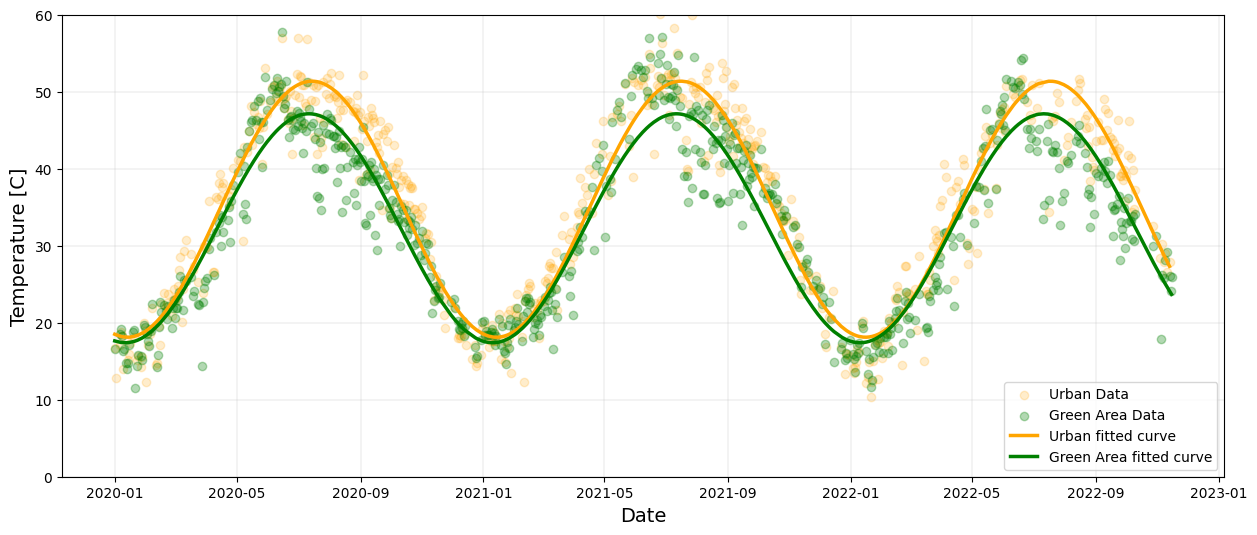

In [138]:
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(lst_df_urban['datetime'],lst_df_urban['LST_Day_1km'],c='orange',alpha=0.2,label='Urban Data')
ax.scatter(lst_df_rural['datetime'],lst_df_rural['LST_Day_1km'],c='Green',alpha=0.3,label='Green Area Data')
ax.plot(lst_df_urban['datetime'],fit_func(x_data_u,params_u[0],params_u[1],params_u[2],params_u[3]),label='Urban fitted curve',c="orange",lw=2.5)
ax.plot(lst_df_rural['datetime'],fit_func(x_data_r,params_r[0],params_r[1],params_r[2],params_r[3]),label='Green Area fitted curve',c="Green",lw=2.5)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 60)
ax.grid(lw=0.2)
ax.legend(fontsize=10, loc='lower right')

plt.show()